In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, jacobian, lax, vmap, pmap

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate as si
import scipy.optimize as so

import time

In [2]:
# given time series observations, our goal here is to find f(x)
# such that the observations can be predicted using the ODE
# dx/dt = \dot{x} = f(x)

In [3]:
# typical supervised learning task
# you have a lot of (x, y) pairs
# you want a function y = f(x)
# our problem is different, we never directly observe the thing we're trying to learn (which is f(x))1q
dilfac = 1
numsteps = 600

In [4]:
alltraj = np.load('heh+_training_data.npz')
alltraj.shape

(90, 20000, 2, 2)

In [5]:
#flatten density matrices into a vector and reshape to be in form 
trajs = []
for i in range(alltraj.shape[0]):
    traj = alltraj[i]
    steps  = []
    for j in range(numsteps):
        vec = np.zeros((2,),dtype=np.float64)
        denmat = traj[j]
        v1 = denmat[0][0]
        v2 = denmat[1][1]
        vec[0] = v1.real
        vec[1] = v2.real
        steps.append(vec)
    trajs.append(steps)
trajs = np.array(trajs)
trajs.shape

(90, 600, 2)

In [6]:
# now pretend we don't know the vector field but we want to learn it
# set up a neural network model for f
nlayers = 4

# units per hidden layer
uphl = 128

# dimension of vector field
vfd = 2

# set up neural network parameters
layerwidths = [vfd,uphl,uphl,uphl,vfd]
numparams = 0
numweights = 0
numbiases = 0
for j in range(nlayers):
    numparams += layerwidths[j]*layerwidths[j+1] + layerwidths[j+1]
    numweights += layerwidths[j]*layerwidths[j+1]
    numbiases += layerwidths[j+1]

# print out total number of parameters
print(numparams)

# definition of actual neural network function
def neuralf(x, theta):
    filt = []
    si = 0
    ei = layerwidths[0]*layerwidths[1]
    filt.append( theta[si:ei].reshape((layerwidths[0],layerwidths[1])) )
    si += layerwidths[0]*layerwidths[1]
    ei += layerwidths[1]*layerwidths[2]
    filt.append( theta[si:ei].reshape((layerwidths[1],layerwidths[2])) )
    si += layerwidths[1]*layerwidths[2]
    ei += layerwidths[2]*layerwidths[3]
    filt.append( theta[si:ei].reshape((layerwidths[2],layerwidths[3])) )
    si += layerwidths[2]*layerwidths[3]
    ei += layerwidths[3]*layerwidths[4]
    filt.append( theta[si:ei].reshape((layerwidths[3],layerwidths[4])) )
    bias = []
    si += layerwidths[3]*layerwidths[4]
    ei += layerwidths[1]
    bias.append( theta[si:ei] )
    si += layerwidths[1]
    ei += layerwidths[2]
    bias.append( theta[si:ei] )
    si += layerwidths[2]
    ei += layerwidths[3]
    bias.append( theta[si:ei] )
    si += layerwidths[3]
    ei += layerwidths[4]
    bias.append( theta[si:ei] )
    inplyr = x
    h1 = jax.nn.selu( inplyr @ filt[0] + bias[0] )
    h2 = jax.nn.selu( h1 @ filt[1] + bias[1] )
    h3 = jax.nn.selu( h2 @ filt[2] + bias[2] )
    h4 = h3 @ filt[3] + bias[3]
    return h4

33666


In [7]:
from jax.experimental import ode

In [8]:
# move training data from NumPy to JAX
jalltraj = jnp.array(trajs)
print(jalltraj.shape)

(90, 600, 2)


In [9]:
# define JAX function to compute one predicted trajectory
def predtraj(y0, theta):
    def rhsfunc(y, t):
        return neuralf(y, theta)
    
    intdt = 0.08268/dilfac
    intnpts = (numsteps-1)*dilfac + 1
    inttint = np.arange(intnpts)*intdt
    return ode.odeint(rhsfunc, y0, inttint)

In [10]:
# now parallelize the above function to handle many initial conditions but one theta
vpredtraj = vmap(predtraj, in_axes=(0, None))

In [11]:
# now define loss (or objective function)
def obj(y, theta):
    # compute all predicted trajectories for fixed theta
    predfine = predtraj(y[0,:], theta)
    pred = predfine[::dilfac, :]
    # now compute mean squared errors between predictions and training data
    return jnp.mean(jnp.square(pred - y))

In [12]:
# use JAX to compile objective function
jobj = jit(obj)

# use JAX to compute gradient and compile it
jgradobj = jit(grad(obj,1))

In [13]:
dfdx = jacobian(neuralf, 0)
dfdtheta = jacobian(neuralf, 1)

In [14]:
vdfdtheta = vmap(dfdtheta, in_axes=(0,None))

In [15]:
# adjoint method to compute gradient of objective function
# here y stands for one trajectory of observations, of shape (numsteps, 2)
def newlagwithgrad(y, theta):
    intdt = 0.08268/dilfac
    intnpts = (numsteps-1)*dilfac + 1
    inttint = np.arange(intnpts)*intdt
    
    # solve forward problem and compute residual
    def rhsfunc(y, t):
        return neuralf(y, theta)
    
    xfine = ode.odeint(rhsfunc, y[0,:], inttint)
    
    x = xfine[::dilfac,:]
    resid = 2*(x - y)
    
    # compute and save loss for later
    obj = jnp.mean(jnp.square(resid))
    
    # trapezoid rule quadrature weights
    w = jnp.concatenate([jnp.array([0.5]),jnp.ones(intnpts-2),jnp.array([0.5])])
    
    # backward-in-time loop body
    # Heun's method backward in time
    inth = -intdt
    
    def bodylamb(j, lambmfine):
       
        #import pdb; pdb.set_trace()
        feval1 = -lambmfine[intnpts-j, :] @ dfdx(xfine[intnpts-j, :], theta) #@ dfdy(xfine[intnpts-j, :].real,xfine[intnpts-j, :].imag, theta)
        lambtilde = lambmfine[intnpts-j, :] + inth*feval1
        feval2 = -lambtilde @ dfdx(xfine[intnpts-j-1, :], theta) #@ dfdy(xfine[intnpts-j-1,:].real ,xfine[intnpts-j-1, :].imag , theta)
        prevlamb = lambmfine[intnpts-j, :] + (inth/2.0)*(feval1 + feval2)
        prevlamb += ((intnpts-j-1) % dilfac == 0) * resid[(intnpts-j-1)//dilfac, :]
        return lambmfine.at[intnpts-j-1].set( prevlamb )
    
    # loop initialization
    lambmat = jnp.concatenate([ jnp.zeros((intnpts-1, vfd)), resid[[numsteps-1],:] ])
    
    # actually loop
    lambout = lax.fori_loop(1, intnpts, bodylamb, lambmat)
    
    # straight out of the notes
    allg = vdfdtheta(xfine, theta)
    gradtheta = intdt*jnp.einsum('ij,ijk,i->k',lambout,allg,w)
    gradtheta *= (1.0/(2*numsteps))
    return obj, gradtheta

jnlwg = jit(newlagwithgrad)

In [16]:
jnewlagwithgrad = jit(newlagwithgrad)

In [17]:
# random initializer
def glorotinit():
    theta = []
    sd = np.sqrt(2.0 / (layerwidths[0]+layerwidths[1]))
    theta.append( np.random.normal(size=layerwidths[0]*layerwidths[1])*sd )
    sd = np.sqrt(2.0 / (layerwidths[1]+layerwidths[2]))
    theta.append( np.random.normal(size=layerwidths[1]*layerwidths[2])*sd )
    sd = np.sqrt(2.0 / (layerwidths[2]+layerwidths[3]))
    theta.append( np.random.normal(size=layerwidths[2]*layerwidths[3])*sd )
    sd = np.sqrt(2.0 / (layerwidths[3]+layerwidths[4]))
    theta.append( np.random.normal(size=layerwidths[3]*layerwidths[4])*sd )
    theta.append( np.zeros(numbiases) )
    theta = np.concatenate(theta)
    return theta

theta0 = glorotinit()

In [18]:
start = time.time()
myobj, mygrad = jnewlagwithgrad(jalltraj[0], theta0)
end = time.time()
print(end-start)

start = time.time()
jaxobj = jobj(jalltraj[0], theta0)
jaxgrad = jgradobj(jalltraj[0], theta0)
end = time.time()
print(end-start)

print(jnp.mean(jnp.abs(jaxgrad-mygrad)))

2.3823065757751465
7.610955476760864
23314.142901468942


In [19]:
jvnewlagwithgrad = jit(vmap(newlagwithgrad, in_axes=(0,None)))

In [20]:
# # for debugging purposes
# tobj, tgrad = jvnewlagwithgrad(jalltraj, theta0)

In [21]:
# tobj.shape, tgrad.shape

In [22]:
# wrap functions so that we can use them in standard NumPy/SciPy
def objgradSP(theta):
    jaxobj, jaxgrads = jvnewlagwithgrad(jalltraj, theta)
    return jnp.mean(jaxobj).item(), np.array(jnp.mean(jaxgrads,0))

In [23]:
# def siobj(x):
#     return np.mean(jvobj(jalltraj,x))

# def sigrad(x):
#     jaxobj, jaxgrad = jvnewlagwithgrad(jalltraj,x)
#     return np.array(jnp.mean( jaxgrad, axis=0 ))

In [24]:
# # trust region optimizer with SR1 update
# res = so.minimize(fun=objgradSP, jac=True, x0=theta0, method='trust-constr', 
#                   hess=so.SR1(), options={'gtol': 1e-6, 'xtol': 1e-6, 'verbose': 2})

# # L-BFGS-B optimizer
# # res = so.minimize(fun=siobj, jac=sigrad, x0=theta0, method='L-BFGS-B',
# #                   options={'gtol': 1e-8, 'ftol':1e-8, 'iprint':1})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +9.6535e+07 | 1.00e+00 | 4.85e+08 | 0.00e+00 |
|   2   |   2   |   1   | +7.3846e+00 | 1.00e+00 | 1.70e+00 | 0.00e+00 |
|   3   |   3   |   2   | +7.3846e+00 | 1.00e+00 | 1.70e+00 | 0.00e+00 |
|   4   |   4   |   4   | +1.3914e+00 | 1.76e+00 | 7.75e-01 | 0.00e+00 |
|   5   |   5   |   7   | +4.3043e-01 | 1.76e+00 | 3.32e-01 | 0.00e+00 |
|   6   |   6   |  10   | +4.2419e-01 | 1.76e+00 | 3.08e-01 | 0.00e+00 |
|   7   |   7   |  11   | +4.2419e-01 | 1.76e+00 | 3.08e-01 | 0.00e+00 |
|   8   |   8   |  15   | +2.4225e-02 | 1.76e+00 | 8.30e-02 | 0.00e+00 |
|   9   |   9   |  18   | +1.6264e-02 | 1.76e+00 | 2.13e-02 | 0.00e+00 |
|  10   |  10   |  21   | +1.5134e-02 | 1.76e+00 | 1.24e-02 | 0.00e+00 |
|  11   |  11   |  24   | +1.4897e-02 | 1.76e+00 | 3.36e-03 | 0.00e+00 |
|  12   |  12   |  27   | +1.4880e-02 | 1.76e+00 | 

In [37]:
jvobj = vmap(jobj, in_axes=(0,None))

In [48]:
theta0 = glorotinit()

In [60]:
jalltraj[0,0,0]

DeviceArray(1.92558057, dtype=float64)

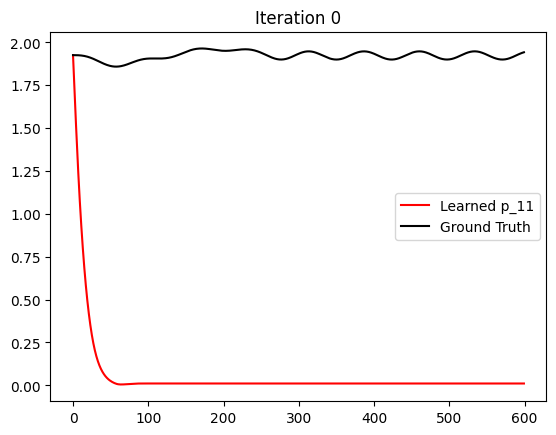

[0, DeviceArray(14.73947846, dtype=float64), 192.058173509892]


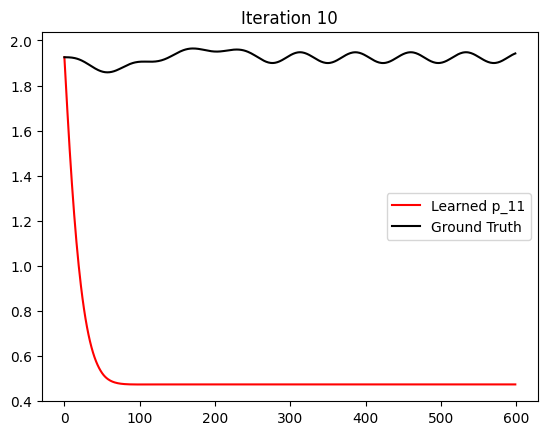

[10, DeviceArray(4.59157978, dtype=float64), 10.44611029712642]


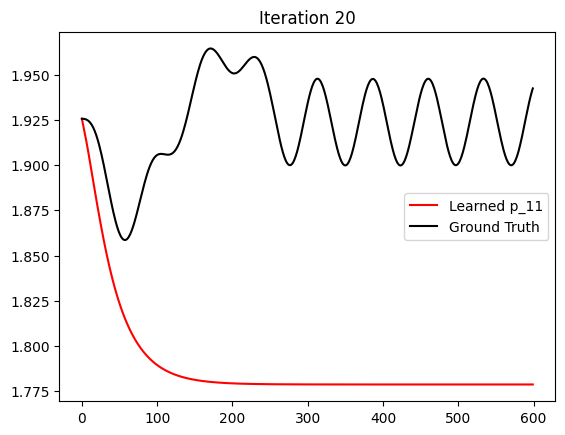

[20, DeviceArray(0.52023578, dtype=float64), 4.967078368611668]


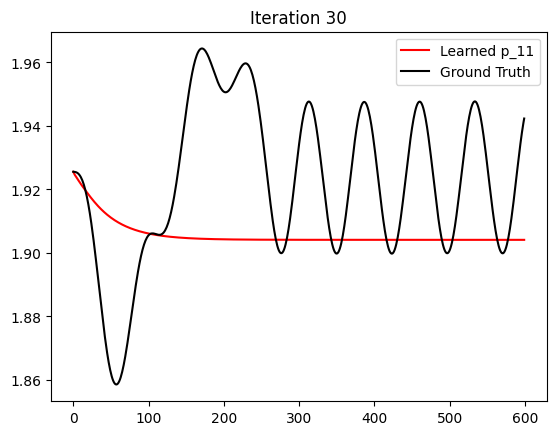

[30, DeviceArray(0.0443398, dtype=float64), 1.7330296353323107]


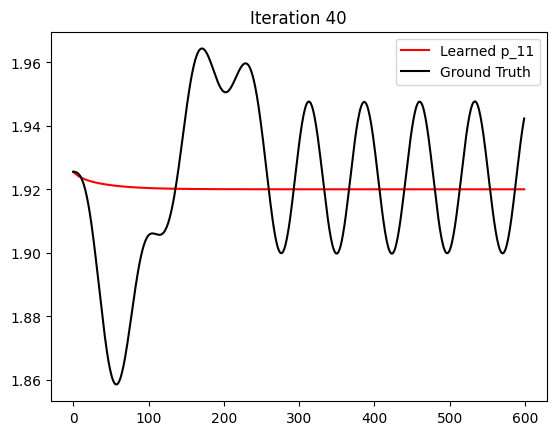

[40, DeviceArray(0.00513811, dtype=float64), 0.4184574395401916]


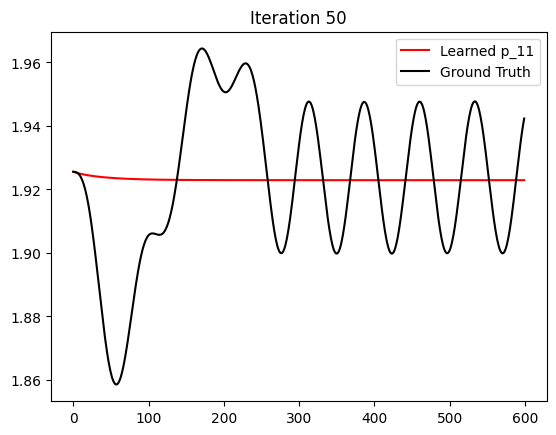

[50, DeviceArray(0.00269857, dtype=float64), 0.11291253962242814]


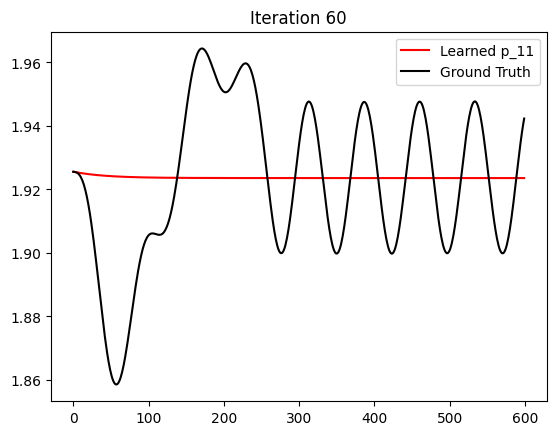

[60, DeviceArray(0.00252478, dtype=float64), 0.02845317102017894]


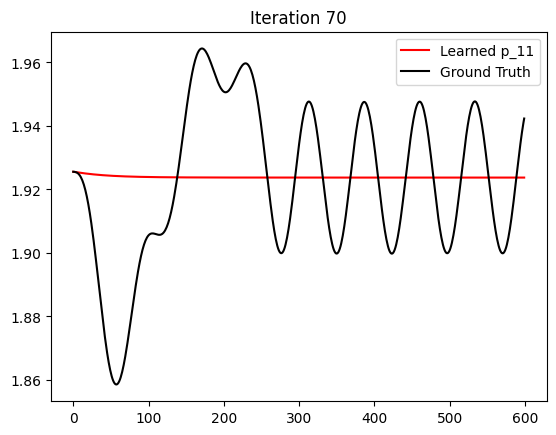

[70, DeviceArray(0.00251378, dtype=float64), 0.007157203143733456]


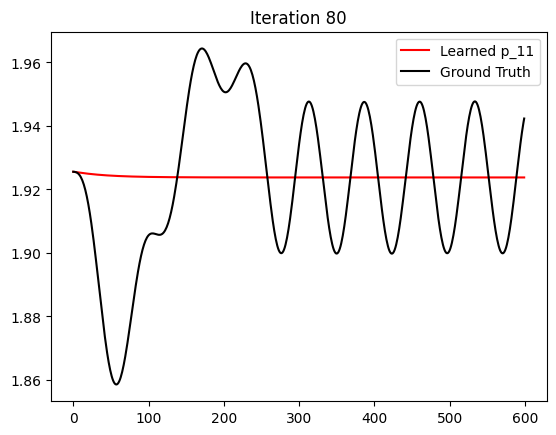

[80, DeviceArray(0.00251309, dtype=float64), 0.0018023740373402076]


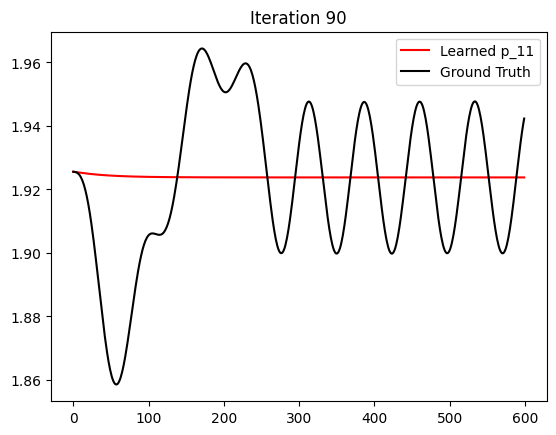

[90, DeviceArray(0.00251304, dtype=float64), 0.00045793532450437294]


In [70]:
lr = 1e-3
theta = theta0
maxiters = 100
for j in range(maxiters):
    myobj, thisgrad = jnewlagwithgrad(jalltraj[0], theta)
    theta -= lr*thisgrad
    loss = myobj
    if j % 10 == 0:
        pred = predtraj(jalltraj[0,0,:],theta)
        plt.plot(pred[:,0], color='red')
        plt.plot(jalltraj[0,:,0], color='black')
        plt.legend(['Learned p_11', 'Ground Truth'])
        plt.title('Iteration ' +str(j))
        plt.show()
        lr *= 0.999
        print([j, loss, np.linalg.norm(thisgrad)])

In [25]:
#needs IC
allpreds = vpredtraj(jalltraj[:,0,:], jnp.array(res.x))

In [26]:
learnedtrajs = []
for i in range(allpreds.shape[0]):
    traj = allpreds[0]
    steps  = []
    for j in range(traj.shape[0]):
        diag = traj[0]
        steps.append(np.diag(diag))
    learnedtrajs.append(steps)

In [27]:
learnedtrajs = np.array(learnedtrajs)

In [28]:
learnedtrajs.shape

(90, 600, 2, 2)

In [29]:
# # for a grid of initial conditions, generate trajectories
# # this is a phase portrait of the LEARNED DYNAMICAL SYSTEM
# plt.figure(figsize=(10,6))
# for i in range(allpreds.shape[0]):
#     plt.plot(allpreds[i,:,1])

# plt.show()


In [30]:
# # this is a phase portrait of the GROUND TRUTH DYNAMICAL SYSTEM
# plt.figure(figsize=(10,6))
# for i in range(allpreds.shape[0]):
#     plt.plot(trajs[i,:,1].real)

# plt.show()


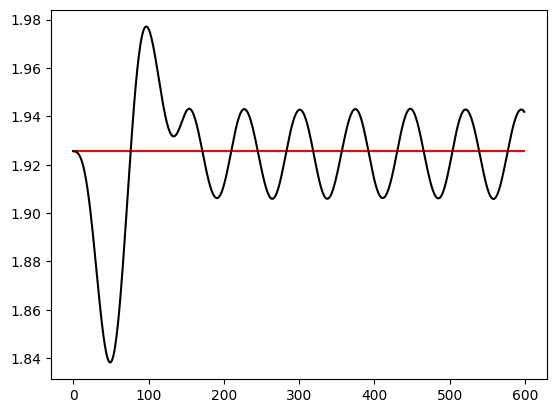

In [31]:
plt.plot(jnp.real(learnedtrajs[10][:,0,0]),color='red')
plt.plot(jnp.real(alltraj[10][:numsteps,0,0]),color='black')

In [32]:
0.5*jnp.mean(jnp.square(allpreds[:,:,0] - trajs[:,:,0]))

DeviceArray(0.0018579, dtype=float64)

In [33]:
0.5*jnp.mean(jnp.square(allpreds[:,:,1] - trajs[:,:,1]))

DeviceArray(0.00185928, dtype=float64)

In [34]:
0.5*jnp.mean(jnp.square(allpreds[:,:,:] - trajs[:,:,:]))

DeviceArray(0.00185859, dtype=float64)